In [68]:
import os
import random
import numpy as np
import json
import matplotlib.pyplot
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE

%matplotlib inline

In [69]:
images, pca_features, pca = pickle.load(open('data/features/features_from_one_folder.p', 'rb'))

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

image: data/images_one_folder/50207003_13.jpeg, features: -28.16,-5.06,6.76,-3.77... 
image: data/images_one_folder/7906845_2.jpg, features: -3.73,-2.54,-5.18,3.17... 
image: data/images_one_folder/38779697_9.jpg, features: -4.02,-11.00,-13.88,-1.62... 
image: data/images_one_folder/6883371_1.jpg, features: 17.23,-11.70,-7.80,-12.01... 
image: data/images_one_folder/14881274_1.jpg, features: 19.03,15.18,20.54,-0.42... 


In [70]:
num_images_to_plot = 10239

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [71]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=200, perplexity=65, angle=0.10, verbose=2).fit_transform(X)

[t-SNE] Computing 196 nearest neighbors...
[t-SNE] Indexed 10239 samples in 0.001s...
[t-SNE] Computed neighbors for 10239 samples in 4.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10239
[t-SNE] Computed conditional probabilities for sample 2000 / 10239
[t-SNE] Computed conditional probabilities for sample 3000 / 10239
[t-SNE] Computed conditional probabilities for sample 4000 / 10239
[t-SNE] Computed conditional probabilities for sample 5000 / 10239
[t-SNE] Computed conditional probabilities for sample 6000 / 10239
[t-SNE] Computed conditional probabilities for sample 7000 / 10239
[t-SNE] Computed conditional probabilities for sample 8000 / 10239
[t-SNE] Computed conditional probabilities for sample 9000 / 10239
[t-SNE] Computed conditional probabilities for sample 10000 / 10239
[t-SNE] Computed conditional probabilities for sample 10239 / 10239
[t-SNE] Mean sigma: 11.904514
[t-SNE] Computed conditional probabilities in 1.022s
[t-SNE] Iteration 50: error = 87.6

In [72]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

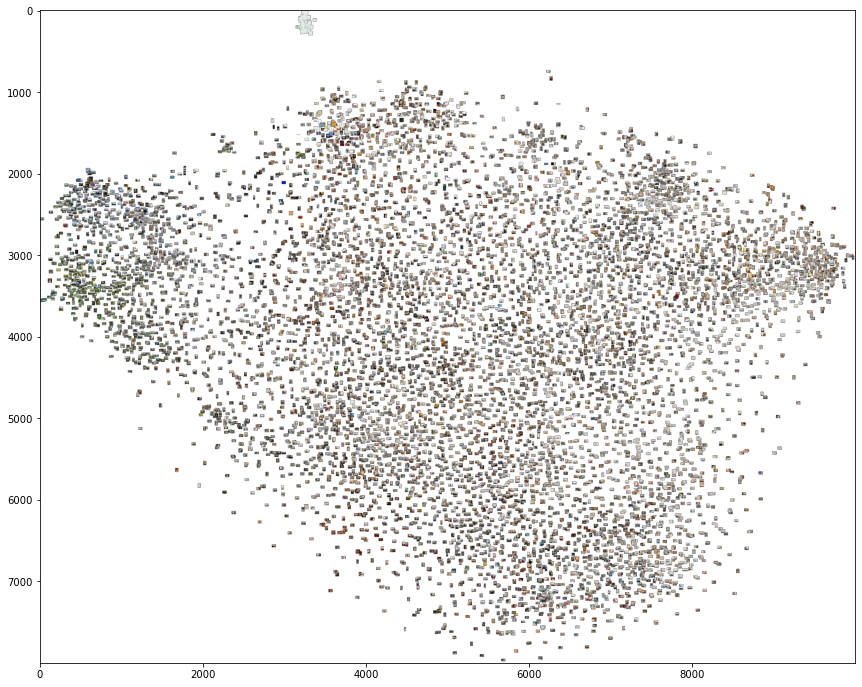

In [73]:
width = 10000
height = 8000
max_dim = 50

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [74]:
full_image.save("clusters.png")

In [75]:
tsne_path = "clusters.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to clusters.json


In [76]:
import rasterfairy

# nx * ny ~= 10000, the number of images
nx = 102
ny = 102

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

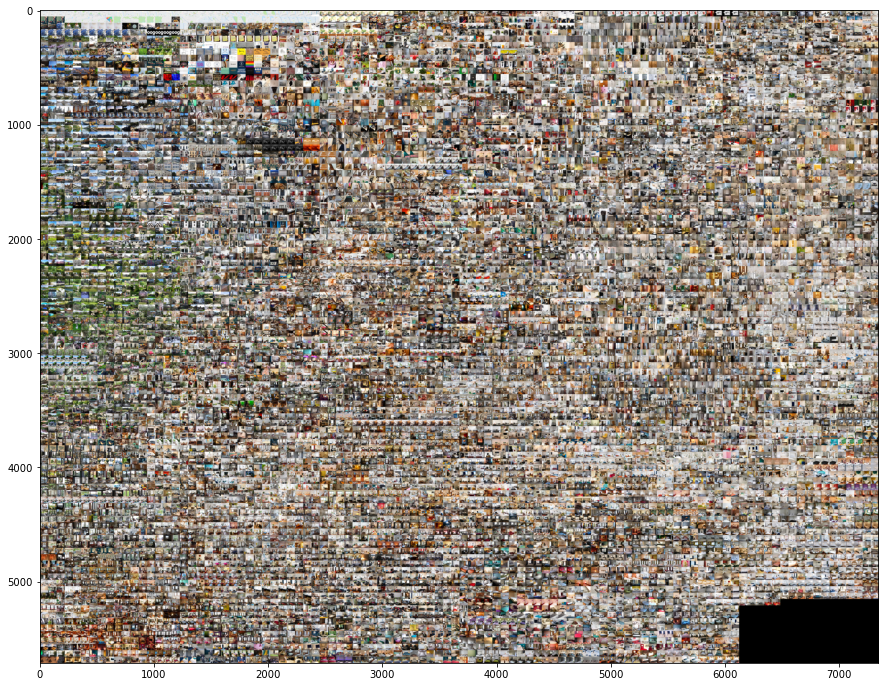

In [77]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [78]:
grid_image.save("clusters_spread.jpg")